In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pystan
import scipy
import sys
sys.path.append("..")
import bayesian_anova

Using gpu device 1: GeForce GTX 980 (CNMeM is enabled with initial size: 35.0% of memory, cuDNN 5103)


In [2]:
cols = ['experiment_name',
        'test_acc',
        'train_time',
        'entropy__auc',
        'entropy_expectation__auc',
        'classifier__auc']

In [3]:
experiments = ['convolutional', 'convolutional-dropout', 'convolutional-poor-bayesian']

In [4]:
dfs = []
for exp in experiments:
    df_with = pd.read_csv(exp+'_with_unknown.csv')
    df_with_results = df_with[cols].set_index('experiment_name')
    df_without = pd.read_csv(exp+'_out_unknown.csv')
    df_without_results = df_without[cols].set_index('experiment_name')
    dfs.append([exp, df_with_results, df_without_results])

In [5]:
results_cols = ['experiment',
                'in_test_acc', 'out_test_acc',
                'in_train_time', 'out_train_time',
                'in_entropy_auc', 'out_entropy_auc',
                'in_entropy_expectation_auc', 'out_entropy_expectation_auc',
                'in_classifier_auc', 'out_classifier_auc']

dfs_results = []
for exp, df_with, df_without in dfs:
    results = pd.DataFrame(columns=results_cols)
    for (in_key, *in_row), (out_key, *out_row) in zip(df_with.itertuples(), df_without.itertuples()):
        assert in_key == out_key
        results.loc[len(results)] = [
            str(in_key),
            in_row[0], out_row[0],
            in_row[1], out_row[1],
            in_row[2], out_row[2],
            in_row[3], out_row[3],
            in_row[4], out_row[4],
        ]
    dfs_results.append([exp, results])

In [6]:
final_results_cols = ['experiment']
for c in results_cols[1:]:
    for exp, _ in dfs_results:
        final_results_cols.append(exp+'_'+c)

In [7]:
final_results = pd.DataFrame(columns=final_results_cols)
for key_row in zip(*[df.itertuples() for exp, df in dfs_results]):
    for i in range(1, len(key_row)):
        _, *prev_row = key_row[i-1]
        _, *row = key_row[i]
        assert prev_row[0] == row[0]
        
    _, *row = key_row[0]
    new_row = [row[0]]
    
    for c in range(1, len(results_cols)):
        for _, *row in key_row:
            new_row.append(row[c])

    final_results.loc[len(final_results)] = new_row
final_results.columns

Index(['experiment', 'convolutional_in_test_acc',
       'convolutional-dropout_in_test_acc',
       'convolutional-poor-bayesian_in_test_acc', 'convolutional_out_test_acc',
       'convolutional-dropout_out_test_acc',
       'convolutional-poor-bayesian_out_test_acc',
       'convolutional_in_train_time', 'convolutional-dropout_in_train_time',
       'convolutional-poor-bayesian_in_train_time',
       'convolutional_out_train_time', 'convolutional-dropout_out_train_time',
       'convolutional-poor-bayesian_out_train_time',
       'convolutional_in_entropy_auc', 'convolutional-dropout_in_entropy_auc',
       'convolutional-poor-bayesian_in_entropy_auc',
       'convolutional_out_entropy_auc',
       'convolutional-dropout_out_entropy_auc',
       'convolutional-poor-bayesian_out_entropy_auc',
       'convolutional_in_entropy_expectation_auc',
       'convolutional-dropout_in_entropy_expectation_auc',
       'convolutional-poor-bayesian_in_entropy_expectation_auc',
       'convolutiona

In [8]:
out_acc = ['convolutional_out_classifier_auc', 'convolutional-dropout_out_classifier_auc', 'convolutional-poor-bayesian_out_classifier_auc']
y_out = final_results[out_acc].values
y_out = scipy.special.logit(y_out)

in_acc = ['convolutional_in_classifier_auc', 'convolutional-dropout_in_classifier_auc', 'convolutional-poor-bayesian_in_classifier_auc']
y_in = final_results[in_acc].values
y_in = scipy.special.logit(y_in)

In [ ]:
model = pystan.StanModel(model_code=bayesian_anova.one_way_code)

In [ ]:
for y in [y_in, y_out]:
    (N, K) = y.shape

    data = {'K': K, 'N': N, 'y': y}
    fit = model.sampling(data=data, iter=10000, chains=4, thin=5)
    
    bayesian_anova.show_results(fit)
    
    trace = fit.extract()
    deterministic = trace['theta'][:,0]
    dropout = trace['theta'][:,1]
    poor_bayesian = trace['theta'][:,2]
    base_mean = trace['mu']
    
    if y is y_in:
        in_mean = np.copy(base_mean)
    else:
        out_mean = np.copy(base_mean)

    bayesian_anova.plot_traces([base_mean, deterministic, dropout, poor_bayesian],
                               ["Mean", "ML effect", "Dropout effect", "OneSample effect"])

    bayesian_anova.effect_difference(dropout, deterministic, 'Dropout', 'ML')
    bayesian_anova.effect_difference(poor_bayesian, deterministic, 'OneSample', 'ML')
    bayesian_anova.effect_difference(poor_bayesian, dropout, 'OneSample', 'Dropout')

bayesian_anova.effect_difference(in_mean, out_mean, 'InOutUnk', 'InOut')

In [9]:
model = pystan.StanModel(model_code=bayesian_anova.two_way_code)

/home/roliveira/anaconda3/lib/python3.5/multiprocessing/reduction.py:50: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  cls(buf, protocol).dump(obj)
/home/roliveira/anaconda3/lib/python3.5/multiprocessing/reduction.py:50: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  cls(buf, protocol).dump(obj)
/home/roliveira/anaconda3/lib/python3.5/multiprocessing/reduction.py:50: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  cls(buf, protocol).dump(obj)
/home/roliveira/anaconda3/lib/python3.5/multiprocessing/reduction.py:50: UserWarning: Pickling fit objects is

Inference for Stan model: anon_model_ddea8e8a9e2bfaae4b2e9caaf410a76a.
4 chains, each with iter=10000; warmup=5000; thin=5; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                   mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu_in              1.37  3.1e-4   0.02   1.33   1.36   1.37   1.38   1.41   4000    1.0
mu_out             1.06  3.2e-4   0.02   1.02   1.05   1.06   1.08    1.1   4000   1.01
theta_free[0]     -0.02  3.2e-4   0.02  -0.07  -0.04  -0.02-8.2e-3 7.9e-3   4000    1.0
theta_free[1]      0.02  2.9e-4   0.02  -0.01 1.1e-3   0.01   0.03   0.05   4000    1.0
sigma_likelihood   0.34  1.6e-4 9.9e-3   0.33   0.34   0.34   0.35   0.36   4000    1.0
sigma_theta        0.15    0.01   0.67 2.4e-3   0.02   0.04   0.09   0.85   4000    1.0
theta[0]          -0.02  3.2e-4   0.02  -0.07  -0.04  -0.02-8.2e-3 7.9e-3   4000    1.0
theta[1]           0.02  2.9e-4   0.02  -0.01 1.1e-3   0.01   0.03   0.05   4000    1.0
theta[2]         9

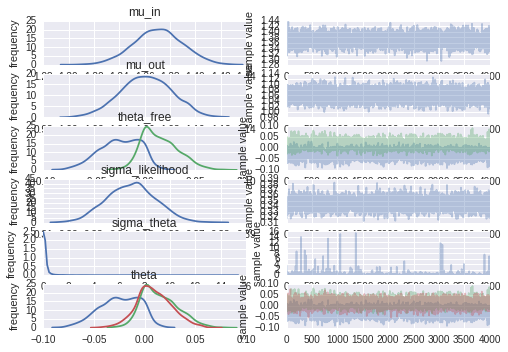

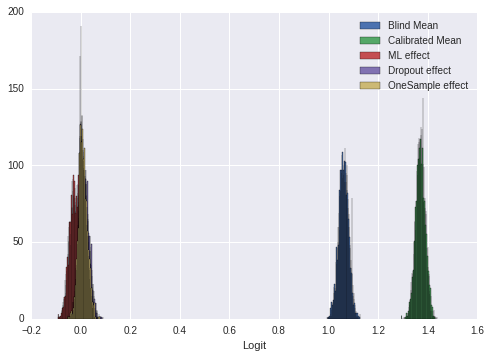

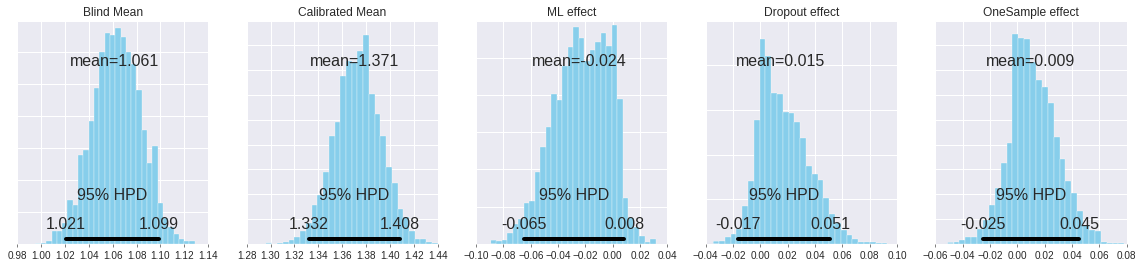

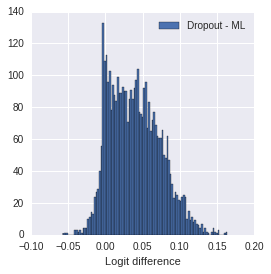

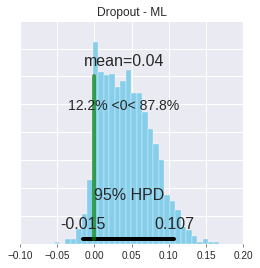

Dropout - ML 95.0 CI: -0.0130698056589 0.110527957098 Pr > 0: 0.87775


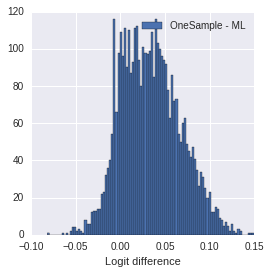

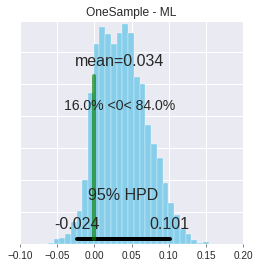

OneSample - ML 95.0 CI: -0.0224853164505 0.102378543282 Pr > 0: 0.83975


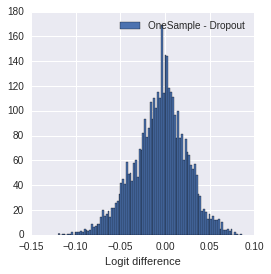

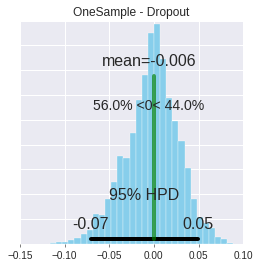

OneSample - Dropout 95.0 CI: -0.069066215691 0.0514561688273 Pr > 0: 0.44025


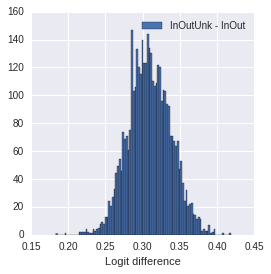

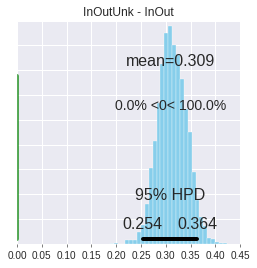

InOutUnk - InOut 95.0 CI: 0.255448936032 0.366280073922 Pr > 0: 1.0


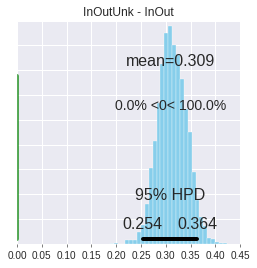

In [10]:
N, K = y_in.shape
data = {'K': K, 'N': N, 'y_in': y_in, 'y_out': y_out}
fit = model.sampling(data=data, iter=10000, chains=4, thin=5)

bayesian_anova.show_results(fit)

trace = fit.extract()
deterministic = trace['theta'][:,0]
dropout = trace['theta'][:,1]
poor_bayesian = trace['theta'][:,2]
in_mean = trace['mu_in']
out_mean = trace['mu_out']

bayesian_anova.plot_traces([out_mean, in_mean, deterministic, dropout, poor_bayesian],
                           ["Blind Mean", "Calibrated Mean", "ML effect", "Dropout effect", "OneSample effect"])

bayesian_anova.effect_difference(dropout, deterministic, 'Dropout', 'ML')
bayesian_anova.effect_difference(poor_bayesian, deterministic, 'OneSample', 'ML')
bayesian_anova.effect_difference(poor_bayesian, dropout, 'OneSample', 'Dropout')

bayesian_anova.effect_difference(in_mean, out_mean, 'InOutUnk', 'InOut')